# Evaluation notebook


In [1]:
import k_traceoids as ktr
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from scipy.stats import entropy
from collections import Counter
import pm4py

warnings.filterwarnings(module="pandas", action="ignore")

In [3]:
def get_result_dir(ds, pm, cc, k, max_iterations, base_dir):
    sub_dir = f"{ds}/pm_{pm}/cc_{cc}/k_{k}/max_iter_{max_iterations}",
    result_dir = os.path.join(base_dir, sub_dir)
    return result_dir

## Get parameters to read data

In [10]:
base_dir = "results/"

ds = "bpi2019-sample"
fig_dir = "./figures/{ds}/"

pms = [
    'imf', "hm", 
]
ccs = [
    "tbr", "al",
]
ks = range(2, 11, 1)
max_iterations = 100 

## Cluster Count

In [11]:
cluster_counts = []

for k in ks:
    for pm in pms:
        for cc in ccs:
            try:
                p = os.path.join(
                    base_dir, 
                    f"{ds}/pm_{pm}/cc_{cc}/k_{k}/max_iter_{max_iterations}",
                )
                ca = pd.read_csv(os.path.join(p, "ca.csv"))
            except FileNotFoundError:
                # TODO deal with it
                continue

            ca_col = ca.columns[-1]
            ca_count = ca[[ca_col]].reset_index().groupby(ca_col).count()
            ca_count.reset_index(inplace=True)
            ca_count.columns = ["Cluster", "Nb Traces"]
            ca_count["Model"] = pm
            ca_count["Conformance"] = cc
            ca_count["k"] = k

            ca_count = ca_count[['k', 'Model', 'Conformance', 'Cluster', 'Nb Traces']]
            cluster_counts.append(ca_count)
cluster_counts = pd.concat(cluster_counts)
cluster_counts.reset_index(drop=True, inplace=True)

In [12]:
cluster_counts["Nb Traces"] = cluster_counts["Nb Traces"].astype(int)

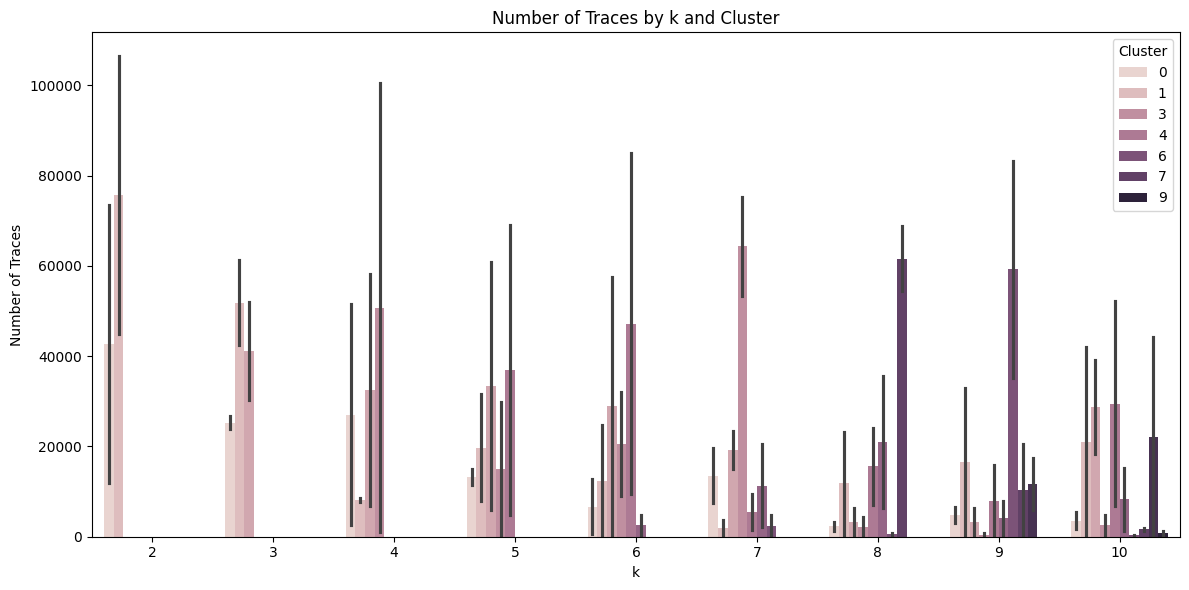

In [13]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=cluster_counts,
    x='k',
    y='Nb Traces',
    hue='Cluster'
)
plt.title("Number of Traces by k and Cluster")
plt.ylabel("Number of Traces")
plt.xlabel("k")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

## Entropy

In [14]:
# Entropy from SciPy
result = []
for index, df_ in cluster_counts.groupby(by=["k", "Model", "Conformance"]):
    total_nb_traces = df_["Nb Traces"].sum()
    probabilities = df_["Nb Traces"] / total_nb_traces 
    entropy_value = entropy(probabilities)
    result.append(
        [*index] + [entropy_value]
    )

In [15]:
cluster_entropy = pd.DataFrame(result)
cluster_entropy.columns = ["k", "Model", "Conformance", "Entropy"]
cluster_entropy["max_entropy"] = np.log(cluster_entropy["k"])
cluster_entropy["Scaled Entropy"] = cluster_entropy["Entropy"] / cluster_entropy["max_entropy"]

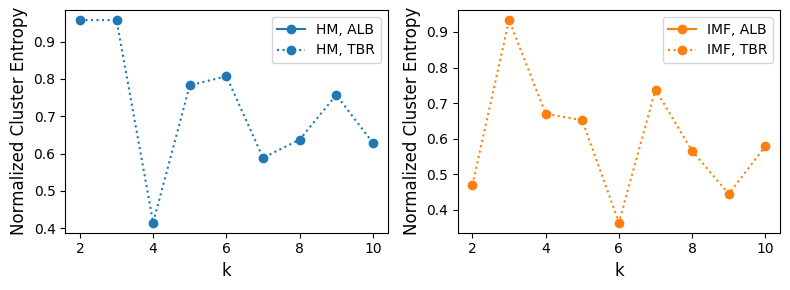

In [17]:
colormap= mpl.colormaps["tab10"]
colors = {
    # "dfg": colormap(0),
    "hm": colormap(0),
    "imf": colormap(1),
}

linestyles = {
    "al": "-",
    "tbr": ":",
}

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 3))
axes = axes.flatten()

i = 0 
for model in colors.keys():
    ax = axes[i]
    for conf in linestyles.keys():
        df_ = cluster_entropy[
            (cluster_entropy["Model"] == model) & (cluster_entropy["Conformance"] == conf)
        ]
        x = df_["k"]
        y = df_["Scaled Entropy"]
        ls = linestyles[conf]
        color = colors[model]
        if conf == "al":
            label = f"{model.upper()}, {conf.upper()}B"
        else:
            label = f"{model.upper()}, {conf.upper()}"
        ax.plot(x, y, color=color, linestyle=ls, marker="o", label=label)
        ax.legend(loc="upper right")
    ax.set_ylabel("Normalized Cluster Entropy", fontdict={"size": 12})
    ax.set_xlabel("k", fontdict={"size": 12})
    # ax.set_ylim([0.5, 1.02])
    i += 1
    # ax.set_yscale("log")

fig.tight_layout()
# fig.savefig(f"{fig_dir}/cluster-entropy.png", dpi=300)

In [20]:
# # Table 1:
# cluster_counts["k"].isin([2, 3, 4,])
# 
# p_table = pd.pivot_table(cluster_counts, index = ["k", "Model", "Conformance", "Cluster"])
# p_table["Nb Traces"] = p_table["Nb Traces"].astype(int)
# table_latex = p_table.to_latex(
#     index=True,  # To not include the DataFrame index as a column in the table
#     # caption="Comparison of ML Model Performance Metrics",  # The caption to appear above the table in the LaTeX document
#     # label="tab:model_comparison",  # A label used for referencing the table within the LaTeX document
#     # position="htbp",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
#     # column_format="lccc",  # The format of the columns: left-aligend first column and center-aligned remaining columns as per APA guidelines
#     escape=True,  # Disable escaping LaTeX special characters in the DataFrame
#     # float_format="{:0.2f}".format  # Formats floats to two decimal places
# )
# print()
# print(table_latex)

## Fitness

In [18]:
# Mean Fitness Values

mean_fitnesses = []
for k in ks:
    for pm in pms:
        for cc in ccs:
            try:
                p = os.path.join(
                    base_dir, 
                    f"{ds}/pm_{pm}/cc_{cc}/k_{k}/max_iter_{max_iterations}/fitness",
                )
                iterations = os.listdir(p)
                li = iterations[-1]
            except FileNotFoundError:
                # TODO deal with it
                continue

            fitness = pd.read_csv(os.path.join(p, f"{li}/fitness.csv"))
            fitness = fitness.drop(columns="Unnamed: 0")
            ca = pd.read_csv(os.path.join(p[:-7], "ca.csv"))
            cluster_col = ca.columns[-1]
            ca[["case_index", cluster_col]]

            mean = 0 
            std = 0 
            for cluster in range(k):
                mask = ca[cluster_col] == cluster
                stats = fitness[mask][str(cluster)].describe()
                mean += stats["mean"] * stats["count"]
                std += stats["std"] * stats["count"]


            weighted_std_fitness = std / len(fitness)
            weighted_mean_fitness = mean / len(fitness)
            mean_fitnesses.append((k, pm, cc, weighted_mean_fitness, weighted_std_fitness))
        


In [19]:
mean_fitnesses = pd.DataFrame(mean_fitnesses, columns=["k", "Model", "Conformance", "Mean Fitness", "Std Mean Fitness"])
mean_fitnesses["Std Percent"] = mean_fitnesses["Std Mean Fitness"] * 100 / mean_fitnesses["Mean Fitness"]
mean_fitnesses = np.round(mean_fitnesses, 2)
mean_fitnesses["Std Error"] = mean_fitnesses["Std Mean Fitness"] /np.sqrt(k)

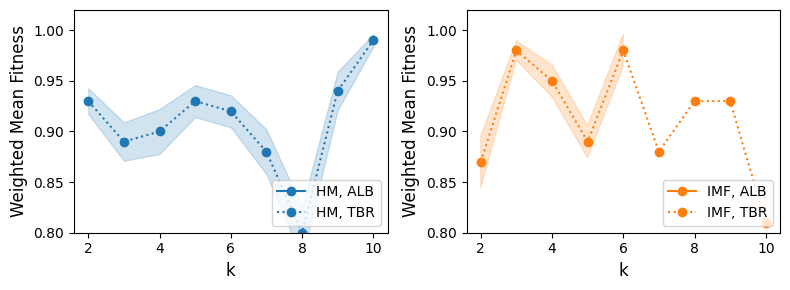

In [20]:
colormap= mpl.colormaps["tab10"]
colors = {
    "hm": colormap(0),
    "imf": colormap(1),
}

linestyles = {
    "al": "-",
    "tbr": ":",
}

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 3))
axes = axes.flatten()

i = 0 
for model in colors.keys():
    ax = axes[i]
    for conf in linestyles.keys():
        df_ = mean_fitnesses[
            (mean_fitnesses["Model"] == model) & (mean_fitnesses["Conformance"] == conf)
        ]
        y_err_lower = df_["Mean Fitness"] - df_["Std Error"]
        y_err_upper = df_["Mean Fitness"] + df_["Std Error"]
        y_err = [y_err_lower, y_err_upper]
        
        x = df_["k"]
        y = df_["Mean Fitness"]
        ls = linestyles[conf]
        color = colors[model]
        if conf == "al":
            label = f"{model.upper()}, {conf.upper()}B"
        else:
            label = f"{model.upper()}, {conf.upper()}"
        ax.plot(x, y, color=color, linestyle=ls, marker="o", label=label)
        ax.fill_between(x, y_err_lower, y_err_upper, color=color, alpha=0.2)
        ax.legend(loc="lower right")
    ax.set_ylabel("Weighted Mean Fitness", fontdict={"size": 12})
    ax.set_xlabel("k", fontdict={"size": 12})
    ax.set_ylim([0.8, 1.02])
    i += 1

fig.tight_layout()
# fig.savefig(f"{fig_dir}/mean-fitness.png", dpi=300)

## Execution times

In [21]:
execution_times = []
for k in ks:
    for pm in pms:
        for cc in ccs:
            try:
                p = os.path.join(
                    base_dir, 
                    f"{ds}/pm_{pm}/cc_{cc}/k_{k}/max_iter_{max_iterations}",
                )
                et = pd.read_csv(os.path.join(p, "execution-times.csv"))
            except FileNotFoundError:
                # TODO deal with it
                continue
            et.drop(columns="Unnamed: 0", inplace=True)
            execution_times.append(
                [k, pm, cc ] + list(et.describe().T[["mean", "std"]].values[0])
            )
execution_times = pd.DataFrame(execution_times)

In [22]:
execution_times.columns = columns=["k", "Model", "Conformance", "Mean Execution Time", "Std Mean Execution Time"]

## Convergence after X Iterations


In [23]:
n_iter = []
for pm in pms:
    for cc in ccs:
        for k in ks:
            try:
                p = os.path.join(
                    base_dir, 
                    f"{ds}/pm_{pm}/cc_{cc}/k_{k}/max_iter_{max_iterations}/models",
                )
                iterations = os.listdir(p)
                ni = len(iterations)
            except FileNotFoundError:
                ni = np.nan
            n_iter.append(
                [k, pm, cc, ni]
            )



In [24]:
n_iter = pd.DataFrame(n_iter)
n_iter.columns = ["k", "Model", "Conformance", "Nb Iterations"]

In [25]:
n_iter

,k,Model,Conformance,Nb Iterations
0,2,imf,tbr,101.0
1,3,imf,tbr,101.0
2,4,imf,tbr,101.0
3,5,imf,tbr,101.0
4,6,imf,tbr,101.0
5,7,imf,tbr,101.0
6,8,imf,tbr,101.0
7,9,imf,tbr,101.0
8,10,imf,tbr,101.0
9,2,imf,al,NaN


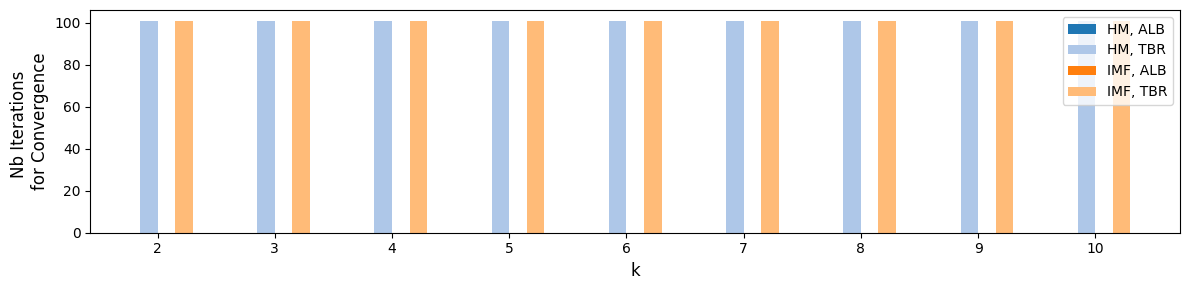

In [27]:

fig, ax = plt.subplots(figsize=(12,3))

colormap = mpl.colormaps["tab20"]

colors = {
    # "dfg": colormap(0),
    "hm": colormap(0),
    "imf": colormap(1),
}

linestyles = {
    "al": "-",
    "tbr": ":",
}

models = list(colors.keys())
confs = list(linestyles.keys())
width = 0.15  # Width of each bar
n_groups = len(models) * len(confs)

unique_ks = sorted(n_iter["k"].unique())
x_indices = np.arange(len(unique_ks))

offset_idx = 0
for model in models:
    for conf in confs:
        df_ = n_iter[
            (n_iter["Model"] == model) & (n_iter["Conformance"] == conf)
        ]
        # Ensure the data is aligned with sorted ks
        y = [df_[df_["k"] == k]["Nb Iterations"].values[0] if k in df_["k"].values else 0 for k in unique_ks]
        offset = (offset_idx - n_groups / 2) * width + width / 2
        if conf == "al":
            label = f"{model.upper()}, {conf.upper()}B"
        else:
            label = f"{model.upper()}, {conf.upper()}"

        ax.bar(x_indices + offset, y, width=width,
               #color=colors[model], 
               color=colormap(offset_idx),
               label=label)
        offset_idx += 1

# ax.set_yscale("log")
ax.set_ylabel("Nb Iterations \nfor Convergence", fontdict={"size": 12})
ax.set_xlabel("k", fontdict={"size": 12})
ax.set_xticks(x_indices)
ax.set_xticklabels(unique_ks)
ax.legend()
plt.tight_layout()
# fig.savefig(f"{fig_dir}/convergence.png", dpi=300)


## Variant distribution 


In [40]:
log = ktr.data.read_log(
    os.path.abspath(f"./datasets/{ds}.xes")
)
trace_to_variant = ktr.data.get_variants(log)
log = log.merge(trace_to_variant)

parsing log, completed traces :: 100%|██████████| 150370/150370 [00:11<00:00, 12776.63it/s]


In [29]:
log.head()


,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola,@@index,@@case_index,variant_id,variant
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN,0,0,0,"(Create Fine, Send Fine)"
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+00:00,NaN,NaN,A1,11.0,NaN,NaN,NaN,NaN,1,0,0,"(Create Fine, Send Fine)"
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN,2,1,1,"(Create Fine, Send Fine, Insert Fine Notificat..."
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.0,NaN,NaN,NaN,NaN,3,1,1,"(Create Fine, Send Fine, Insert Fine Notificat..."
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,NaN,P,P,NaN,NaN,4,1,1,"(Create Fine, Send Fine, Insert Fine Notificat..."


In [30]:
variant_count = log.groupby("variant").count()[["amount"]]
select = variant_count.sort_values(by="amount", ascending=False)[:10]
select = select.reset_index()

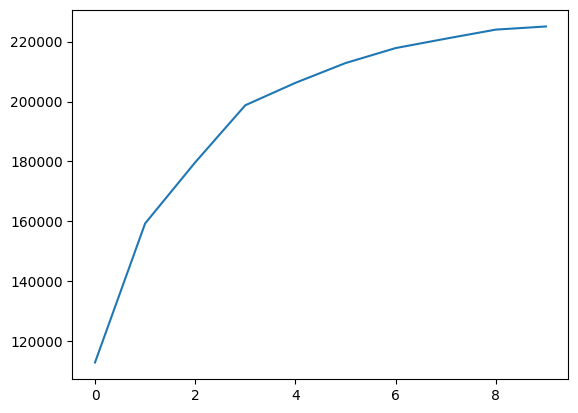

In [31]:
plt.plot(select["amount"].cumsum())

In [32]:
select = select.sort_values(by="amount", ascending=True)
select.reset_index(inplace=True)

Text(0, 0.5, 'Variant')

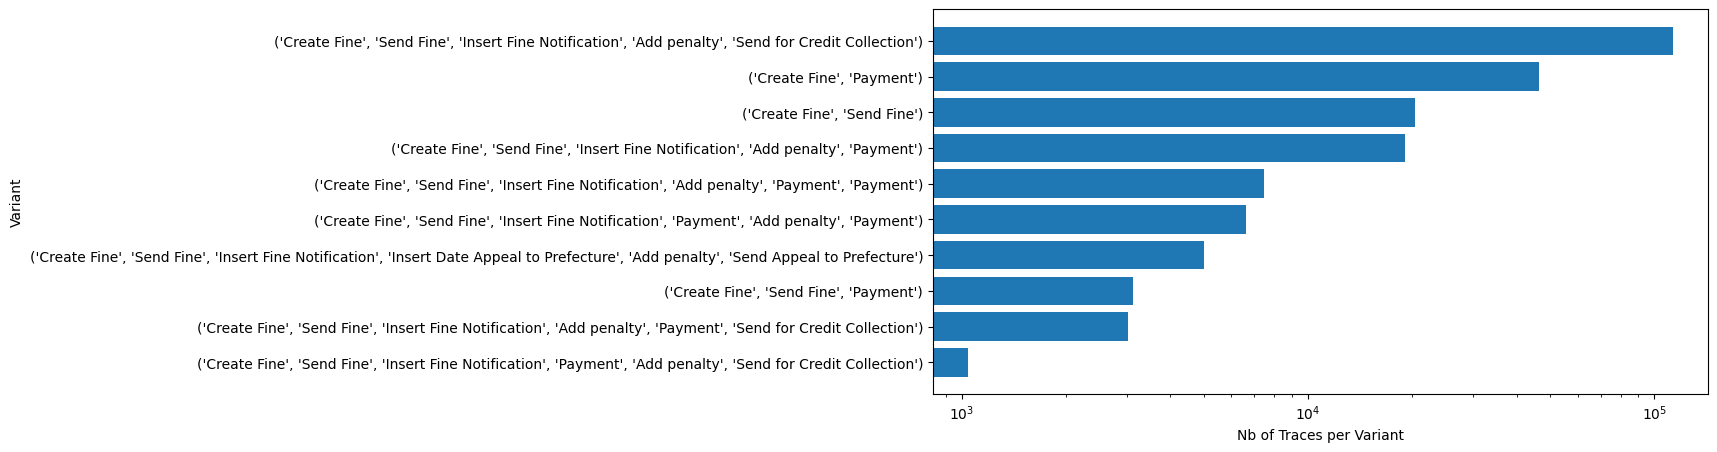

In [33]:
# Most frequent variants
fig, ax = plt.subplots(figsize=(10, 5))

ax.barh(select.index, select["amount"].values)
ax.set_yticks(select.index, labels=select["variant"].values)
ax.set_xscale("log")
ax.set_xlabel("Nb of Traces per Variant")
ax.set_ylabel("Variant")

In [35]:
for k in range(4, 7, 1):
    for pm in ["imf"]:
        for cc in ["al"]:
            print(f"Combination {k}, {pm}, {cc}")
            try:
                p = os.path.join(
                    base_dir, 
                    f"{ds}/pm_{pm}/cc_{cc}/k_{k}/max_iter_{max_iterations}",
                )
                et = pd.read_csv(os.path.join(p, "execution-times.csv"))
            except FileNotFoundError:
                # TODO deal with it
                continue
            ca = pd.read_csv(os.path.join(p, "ca.csv"))
            ca.drop(columns="Unnamed: 0", inplace=True)
            cluster_col = ca.columns[-1]
            ca = ca[["case_index", cluster_col]]
            ca = ca.merge(
                log[["@@case_index", "variant_id", "variant", "concept:name"]],
                left_on="case_index",
                right_on="@@case_index",
            )
            ca.drop(columns="@@case_index", inplace=True)

            activity_count = ca.groupby(by=[cluster_col, "case_index",]).count()["variant_id"]
            activity_count = activity_count.reset_index()
            activity_count.rename(columns={"variant_id": "activity_count"}, inplace=True)
            for c, df_ in activity_count.groupby(cluster_col):
                min_len_act = df_["activity_count"].min()
                max_len_act = df_["activity_count"].max()

                print(f"Cluster {c} length range: {max_len_act - min_len_act}")
                    

Combination 4, imf, al
Cluster 0 length range: 13
Cluster 1 length range: 1
Cluster 2 length range: 17
Cluster 3 length range: 4
Combination 5, imf, al
Cluster 0 length range: 2
Cluster 1 length range: 4
Cluster 2 length range: 16
Cluster 3 length range: 4
Cluster 4 length range: 3
Combination 6, imf, al
Cluster 0 length range: 1
Cluster 1 length range: 2
Cluster 2 length range: 12
Cluster 3 length range: 16
Cluster 4 length range: 3
Cluster 5 length range: 2


In [36]:
k = 4
pm = "imf"
cc = "al"

result = []
p = os.path.join(
    base_dir, 
    f"{ds}/pm_{pm}/cc_{cc}/k_{k}/max_iter_{max_iterations}",
)

ca = pd.read_csv(os.path.join(p, "ca.csv"))
ca.drop(columns="Unnamed: 0", inplace=True)
cluster_col = ca.columns[-1]
ca = ca[["case_index", cluster_col]]
ca = ca.merge(
log[["@@case_index", "variant_id", "variant", "concept:name"]],
left_on="case_index",
right_on="@@case_index",
)
ca.drop(columns="@@case_index", inplace=True)

activity_count = ca.groupby(by=[cluster_col, "case_index",]).count()["variant_id"]
activity_count = activity_count.reset_index()
activity_count.rename(columns={"variant_id": "activity_count"}, inplace=True)
for c, df_ in activity_count.groupby(cluster_col):
    print(f"Cluster {c}")
    min_len_act = df_["activity_count"].min()
    traces_min = df_[df_["activity_count"] == min_len_act]["case_index"].unique()
    print(f"Traces with minimal length: {traces_min}")
    
    max_len_act = df_["activity_count"].max()
    traces_max = df_[df_["activity_count"] == max_len_act]["case_index"].unique()
    print(f"Traces with maximum length: {traces_max}")
    length_range = max_len_act - min_len_act
    result.append(
        [k, pm, cc, c, traces_min, traces_max, length_range]
    )


length_var = pd.DataFrame(result)
length_var.columns=["k", "imf", "al", "cluster", "traces_min", "traces_max", "length_range"]

Cluster 0
Traces with minimal length: [     0     12     27 ... 150350 150352 150363]
Traces with maximum length: [146927]
Cluster 1
Traces with minimal length: [     1      4      7 ... 150367 150368 150369]
Traces with maximum length: [  3137   3237   4534   4662   6163   9059  11180  14183  16255  17083
  17161  17449  19058  24306  24307  24308  24309  24933  25748  25749
  25791  25945  25990  26199  26285  26624  26693  26910  26957  27062
  27072  27083  27103  27525  27526  27527  27528  27724  27726  27957
  27962  28543  28741  44448  45822  45933  47758  47959  48301  50567
  50799  52047  52112  53799  54717  54725  60055  61627  64463  77751
  78900  79077  79280  79896  80622  80969  81554  81621  83344  83608
  84555  85148  88615  89895  90128  90157  90361  90584  90787  93089
  93778  98115 101660 103840 104471 105392 136967 139122 139313 139451
 141048 141279 141543 141619 144020 145215 145863 146274 146292 146294
 146315 146321 146350 146362 146378 146463 146476 146

In [37]:
activity_count.groupby(by=[cluster_col, "activity_count"]).count().reset_index().sort_values(by="activity_count")

,cluster_assignment_2,activity_count,case_index
0,0,2,20385
24,3,2,46371
9,2,3,3505
1,0,3,10
10,2,4,225
2,0,4,1
7,1,5,56514
11,2,5,9533
12,2,6,2879
8,1,6,124


In [38]:
all_seen = []
for c in range(k):
    cis = activity_count[activity_count[cluster_col] == c].sort_values(by="activity_count", ascending=False).case_index
    seen = set()
    for ci in cis:
        trace = tuple(log[log["@@case_index"] == ci]["concept:name"].values)
        seen.add(trace)
    print(f"Unique traces for cluster {c}:")
    print(seen)
    all_seen.append(seen)


Unique traces for cluster 0:
{('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Payment', 'Add penalty', 'Payment', 'Payment'), ('Create Fine', 'Appeal to Judge', 'Send Fine', 'Payment'), ('Create Fine', 'Appeal to Judge', 'Send Fine'), ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Payment', 'Add penalty', 'Payment'), ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Send for Credit Collection'), ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment', 'Payment', 'Payment', 'Send for Credit Collection'), ('Create Fine', 'Send Fine', 'Appeal to Judge'), ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Payment', 'Payment'), ('Create Fine', 'Send Fine')}
Unique traces for cluster 1:
{('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Appeal to Judge', 'Send for Credit

In [ ]:
# Cluster 0 captures loops of one or two behaviours, rightfully grouping together process executions of very differnt lengths (repeated Payment)
# Cluster 1 has a more captures process execution that allow for varaition of order
# Cluster 2 Allows for more diverse behaviours including loops and process 
# Cluster 3 contains a lot of small process executions

In [66]:
for k in range(4):
    for trace in all_seen[k]:
        for event in trace:
            if "Send Appeal" in event:
                print(k, trace)

2 ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Insert Date Appeal to Prefecture', 'Add penalty', 'Send Appeal to Prefecture', 'Payment', 'Payment', 'Payment')
2 ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Insert Date Appeal to Prefecture', 'Send Appeal to Prefecture', 'Receive Result Appeal from Prefecture')
2 ('Create Fine', 'Send Fine', 'Payment', 'Insert Date Appeal to Prefecture', 'Send Appeal to Prefecture')
2 ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Insert Date Appeal to Prefecture', 'Appeal to Judge', 'Send Appeal to Prefecture', 'Add penalty', 'Receive Result Appeal from Prefecture')
2 ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Insert Date Appeal to Prefecture', 'Send Appeal to Prefecture', 'Add penalty', 'Receive Result Appeal from Prefecture', 'Notify Result Appeal to Offender', 'Payment', 'Appeal to Judge')
2 ('Create Fine', 'Send Fine', 'Insert Fine Notification', 'Add penalty', 'Insert Date Appeal to

## Precision of final models

In [39]:
log

,amount,org:resource,dismissal,concept:name,vehicleClass,totalPaymentAmount,lifecycle:transition,time:timestamp,article,points,case:concept:name,expense,notificationType,lastSent,paymentAmount,matricola,@@index,@@case_index,variant_id,variant
0,35.0,561,NIL,Create Fine,A,0.0,complete,2006-07-24 00:00:00+00:00,157.0,0.0,A1,NaN,NaN,NaN,NaN,NaN,0,0,0,"(Create Fine, Send Fine)"
1,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-05 00:00:00+00:00,NaN,NaN,A1,11.00,NaN,NaN,NaN,NaN,1,0,0,"(Create Fine, Send Fine)"
2,35.0,561,NIL,Create Fine,A,0.0,complete,2006-08-02 00:00:00+00:00,157.0,0.0,A100,NaN,NaN,NaN,NaN,NaN,2,1,1,"(Create Fine, Send Fine, Insert Fine Notificat..."
3,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2006-12-12 00:00:00+00:00,NaN,NaN,A100,11.00,NaN,NaN,NaN,NaN,3,1,1,"(Create Fine, Send Fine, Insert Fine Notificat..."
4,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2007-01-15 00:00:00+00:00,NaN,NaN,A100,NaN,P,P,NaN,NaN,4,1,1,"(Create Fine, Send Fine, Insert Fine Notificat..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561465,131.0,25,NIL,Create Fine,A,0.0,complete,2002-09-07 00:00:00+00:00,142.0,0.0,V9999,NaN,NaN,NaN,NaN,NaN,561465,150369,1,"(Create Fine, Send Fine, Insert Fine Notificat..."
561466,NaN,NaN,NaN,Send Fine,NaN,NaN,complete,2002-10-25 00:00:00+00:00,NaN,NaN,V9999,15.16,NaN,NaN,NaN,NaN,561466,150369,1,"(Create Fine, Send Fine, Insert Fine Notificat..."
561467,NaN,NaN,NaN,Insert Fine Notification,NaN,NaN,complete,2002-11-04 00:00:00+00:00,NaN,NaN,V9999,NaN,P,N,NaN,NaN,561467,150369,1,"(Create Fine, Send Fine, Insert Fine Notificat..."
561468,262.0,NaN,NaN,Add penalty,NaN,NaN,complete,2003-01-03 00:00:00+00:00,NaN,NaN,V9999,NaN,NaN,NaN,NaN,NaN,561468,150369,1,"(Create Fine, Send Fine, Insert Fine Notificat..."


In [87]:
# # Ca 15 min
# precision_results = []
# for pm in pms:
#     for cc in ccs:
#         for k in ks:
#             try:
#                 p = os.path.join(
#                     base_dir, 
#                     f"{ds}/pm_{pm}/cc_{cc}/k_{k}/max_iter_{max_iterations}/models",
#                 )
#                 iterations = os.listdir(p)
#                 iteration_dir = iterations[-1]
#             except FileNotFoundError:
#                 continue
#             model_dir = os.path.join(p, iteration_dir)
#             model_file = [f for f in os.listdir(model_dir) if "pnml" in f][-1]
#             model_file_path = os.path.join(model_dir, model_file)
#             net, im, fm = pm4py.read_pnml(model_file_path)
#             precision = pm4py.algo.evaluation.precision.algorithm.apply(log,net,im,fm)
#             precision_results.append(
#                 [k, pm, cc, precision]
#             )
# 
# precisions = pd.DataFrame(precision_results, columns=["Model", "Conformance", "k", "Precision"])

In [ ]:
# precisions.to_csv("precision.csv", index=False)

In [27]:
precisions = pd.read_csv("precision.csv")
precisions.columns = ["k", "Model", "Conformance", "Precision"]

In [28]:
precisions

,k,Model,Conformance,Precision
0,2,imf,tbr,0.613803
1,3,imf,tbr,0.712737
2,4,imf,tbr,0.763258
3,5,imf,tbr,0.999967
4,6,imf,tbr,0.599478
5,7,imf,tbr,0.851669
6,8,imf,tbr,0.868608
7,9,imf,tbr,0.999453
8,10,imf,tbr,0.990854
9,2,imf,al,0.736302


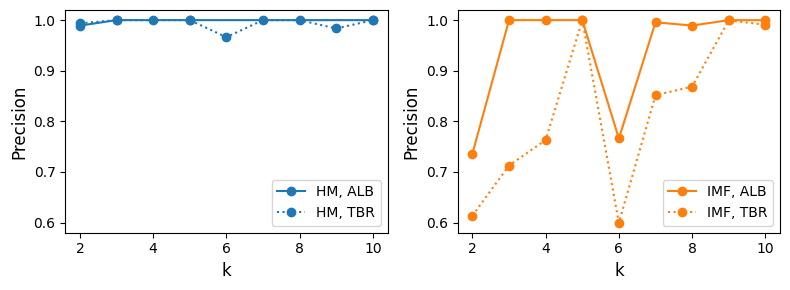

In [ ]:
colormap = mpl.colormaps["tab10"]
colors = {
    "hm": colormap(0),
    "imf": colormap(1),
}

linestyles = {
    "al": "-",
    "tbr": ":",
}

color_legend_elements = [
    mpl.lines.Line2D([0], [0], color=color, lw=2, label=model.upper())
    for model, color in colors.items()
]
# Create custom legend for linestyle (Scenario)
linestyle_legend_elements = [
    mpl.lines.Line2D([0], [0], color=colormap(0), lw=2, linestyle=style, label=conformance.upper())
    for conformance, style in linestyles.items()
]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
axes = axes.flatten()

i = 0
for model in colors.keys():
    ax = axes[i]
    for conf in linestyles.keys():
        df_ = precisions[
            (precisions["Model"] == model) & (precisions["Conformance"] == conf)
        ]
        x = df_["k"]
        y = df_["Precision"]
        ls = linestyles[conf]
        color = colors[model]
        if conf == "al":
            label = f"{model.upper()}, {conf.upper()}B"
        else:
            label = f"{model.upper()}, {conf.upper()}"
        ax.plot(x, y, color=color, linestyle=ls, marker="o", label=label)
        ax.legend(loc="lower right")
    ax.set_ylabel("Precision", fontdict={"size": 12})
    ax.set_xlabel("k", fontdict={"size": 12})
    # ax.set_yscale("log")
    ax.set_ylim([0.58, 1.02])
    i += 1


fig.tight_layout()
fig.savefig(f"{fig_dir}/precision.png", dpi=300)

## Scratch

In [ ]:
all_stats = []
columns = ["ds", "pm", "cc", "k", "max_iterations"]
for path, param in zip(paths, parameters):
    stats = pd.DataFrame(data=list(param)).T 
    stats.columns = columns
    param_col = "-".join([str(p) for p in param])
    stats["param_col"] = param_col

    try:
        exec_time = pd.read_csv(
            os.path.join(path, "execution-times.csv"),
            index_col=0,
        )
    except FileNotFoundError:
        # No sound model created
        stats["execution-times-seconds"] = np.nan
        all_stats.append(stats)
        continue
    stats = stats.loc[stats.index.repeat(len(exec_time))]
    stats.reset_index(drop=True, inplace=True)
    stats["execution-times-seconds"] = exec_time["execution-times-seconds"]
    all_stats.append(stats)

In [ ]:
execution_times = pd.concat(all_stats)
execution_times.reset_index(drop=True, inplace=True)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.boxplot(
    x='param_col',
    y='execution-times-seconds',
    data=execution_times,
    ax=ax
    )
tl = ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


### Cluster Assignment

In [ ]:
# adjusted rand score?
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html
# use final cluster assignment of each k
# For each pm x cc combination, plot the rand score?

In [ ]:
len(pms) * len(ccs) * len(ks) * max_iterations * 2

In [ ]:
pm = "dfg"
cc = "al"

In [ ]:
def get_clusterings(ds, pm, cc,):
    clusterings_k = {}
    no_data_for = []
    for k in ks:
        p = os.path.join(
            base_dir, 
            f"{ds}/pm_{pm}/cc_{cc}/k_{k}/max_iter_{max_iterations}",
        )
        try:
            ca = pd.read_csv(
                os.path.join(p, "ca.csv"),
                index_col=0,
            )
            cluster_labels = ca[ca.columns[-1]].values
        except FileNotFoundError:
            # No data for those params
            cluster_labels = np.ones(len(ca)) * -1
            no_data_for.append(k)
        clusterings_k[k] = cluster_labels
    # TODO no data for?
    return clusterings_k
    

In [ ]:
def plot_cluster_stability(clusterings_k, ks):
    ari_matrix = np.zeros((len(ks), len(ks)))
    for i, k1 in enumerate(ks):
        for j, k2 in enumerate(ks):
            ari_matrix[i, j] = adjusted_rand_score(clusterings_k[k1], clusterings_k[k2])

    # TODO plot no data for differently!

    fig, ax = plt.subplots(figsize=(16,9))
    im = ax.imshow(ari_matrix, cmap='viridis', )# interpolation='nearest')
    plt.colorbar(im, label="Adjusted Rand Index (ARI)")


    ax.set_xticks(np.arange(len(ks)), ks)
    ax.set_yticks(np.arange(len(ks)), ks)
    ax.set_xlabel("k")
    ax.set_ylabel("k")
    ax.set_title(f"Cluster stability for dataset {ds}, model {pm}, conformance check {cc}")

#### Cluster Stability

In [ ]:
for pm in pms:
    for cc in ccs:
        clusterings = get_clusterings(ds, pm, cc)
        plot_cluster_stability(clusterings, ks)

#### Cluster Size, i.e. traces per cluster

In [ ]:
for pm in pms:
    for cc in ccs:
        clusterings = get_clusterings(ds, pm, cc)
        break
    break

In [ ]:
# For each pm x cc
pd.DataFrame(clusterings)#.value_counts()